In [ ]:
import numpy as np
X_train = np.array([[0, 1, 0],
                    [0, 0, 1],
                    [1, 1, 0],
                    [1, 1, 0]])

Y_train = ['Y', 'N', 'Y', 'Y']
X_test = np.array([[1, 1, 0]])

In [ ]:
# Prawdopodobieństwo a priori
def get_label_indices(labels):
  """
  Grupowanie próbek na podstawie ich etykiet i zwrocenie indeksow
  @ param lables: lista etykiet
  @ return: słownik, {klasa1: [indesky], klasa2: [indeksy]}
  """
  from collections import defaultdict
  label_indices = defaultdict(list)
  for index, label in enumerate(labels):
    label_indices[label].append(index)
  return label_indices

In [ ]:
# Test
label_indices = get_label_indices(Y_train)
label_indices

defaultdict(list, {'Y': [0, 2, 3], 'N': [1]})

In [ ]:
def get_prior(label_indices, show=False):
  """
  Wyliczamy prawdopodobieństwo a priori na podstawie próbek treningowych
  @ param label_indices: indeksy próbek pogrupowanych wedlug klas
  @ return: słownik, w ktorym jest etykieta klasy, a wartoscią
            odpowiednir prawdpodobiensw]two a priori
  """
  prior = {label: len(indices) for label, indices in label_indices.items()}

  if show:
    for label, indices_count in prior.items():
      print(f"klasa: {label}, ilosc probek {indices_count}")

  total_count = sum(prior.values())
  for label in prior:
    prior[label] /= total_count
  return prior

In [ ]:
# Test
prior = get_prior(label_indices, True)
prior

klasa: Y, ilosc probek 3
klasa: N, ilosc probek 1


{'Y': 0.75, 'N': 0.25}

In [ ]:
# Prawdpodobienstwo P(cecha | klasa)
def get_likelihood(features, label_indices, smooothing=0):
  """
  Wyliczamy szanse na podstawie próbek treningowych
  @ param features: macierz cech
  @ param label_indices: indeksy probek pogrupowanych wg klas
  @ return: slowknik krorego kluczem jest kalsa a wartoscia wektor
            prawdopodobienstwa warunkoweg P(cecha | klasa)
  """
  likelihood = {}
  for label, indices in label_indices.items():
    print(features[indices, :])
    likelihood[label] = features[indices, :].sum(axis=0) + smooothing
    total_count = len(indices)
    likelihood[label] = likelihood[label] / (total_count + 2)*smooothing

  return likelihood

In [ ]:
# Test
smooothing = 1

likelihood = get_likelihood(features=X_train,
                            label_indices=label_indices,
                            smooothing=smooothing)
likelihood

[[0 1 0]
 [1 1 0]
 [1 1 0]]
[[0 0 1]]


{'Y': array([0.6, 0.8, 0.2]), 'N': array([0.33333333, 0.33333333, 0.66666667])}

In [ ]:
# Prawdopodobienstwo a posterio
def get_posterior(X, prior, likelihood):
  """
  Wyliczanie prawdopodobienstwo a posteriori na podstawie a priori i szansy
  @ param X: próbki treningowe
  @ params prior: słownik, w ktorym kluczem jest etykieta klasy, a wartoscia
                  odpowiednie prawdopodbinstwova posteriori
  @ return: Słownik, w ktorym kluczem jest etykieta klasy, a wartoscia odpowiednie prawdopodbineisto a posteriori
  """
  posteriors = []
  for x in X:
    # A posteriori jest proporcjonalne do a priori*szansa
    posterior = prior.copy()
    for label, likelihood_label in likelihood.items():
      for index, bool_value in enumerate(x):
        posterior[label] *= likelihood_label[index] if bool_value else (1 - likelihood_label[index])
    # Normalizacja aby wszysko sumowalo sie do 1
    sum_posterior = sum(posterior.values())

    for label in posterior:
      if posterior[label] == float('inf'):
        posterior[label] = 1
      else:
        posterior[label] /= sum_posterior

    posteriors.append(posterior.copy())
  return posteriors


In [ ]:
# Test
posteriors = get_posterior(X_test, prior, likelihood)
posteriors

[{'Y': 0.9688512334911538, 'N': 0.031148766508846258}]

### Wykozyskie pakietu sklearn


In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
# Inicjalizacja modelu (alpha, fit_prior) -> (wspolczynik wygladzenia, uzycie prawdopodobiensa a prior)
clf = BernoulliNB(alpha=1.0, fit_prior=True)
# Wykorzystanie metody fit do uczenia
clf.fit(X_train, Y_train)
# Wyiczenie prawdopodobiensta  wykozystujac metode perdict_proba
perd_prob = clf.predict_proba(X_test)
perd_prob

array([[0.03114877, 0.96885123]])

In [ ]:
from pathlib import Path
import requests
import io
import zipfile

def data_downloader(url: str, extraction_path: str, zip_: bool):
    """
    Funkcja pobiera i jesli jest potrzeba to ropakowywuje folder
    @Param url: link do pobrnaia
    @param extraction_path: folder do ktorego jest rozpakowany i pobrany folder
    @param zip_: czy plik ma byc pobrany jako zip
    @return: zwraca scierze dostepu dpo folderu
    """
    # Tworzenie obiektu ścieżki za pomocą url
    if zip_:
        extracted_folder_path = Path(extraction_path) / Path(url.split('/')[-1].split('.')[0])
    else:
        extracted_folder_path = Path(extraction_path) / Path(url.split('/')[-1])

    if extracted_folder_path.exists():
        print("Plik jest już w folderze.")
    else:
        # Pobierz zawartość pliku ZIP
        response = requests.get(url)
        if response.status_code == 200:
            # Otwórz plik ZIP z zawartością zwróconą przez żądanie
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
                # Rozpakuj plik ZIP do wybranego folderu
                zip_ref.extractall(extraction_path)
                print("Plik ZIP został pomyślnie pobrany i rozpakowany.")
        else:
            print("Nie udało się pobrać pliku ZIP")

    return extracted_folder_path

In [ ]:
# pobranie danych fiolmow uzutych do tworzenia rekomendacj

# Adres URL pliku ZIP do pobrania
url = r'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

path = r'data_sets'

data_path = data_downloader(url=url,
                extraction_path=path,
                zip_=True)


Plik jest już w folderze.


In [ ]:
from collections import defaultdict
import csv
### przygotowanie danych (przypisanie nowych indeksow ze wzgledu na to ze brakuje wszyskich danych)
file_path_movies = data_path / Path('movies.csv')

def add_new_move_id(file_path_movies):
    """
    Funkcja zamienia oryginalne ID filmu na jego indeks w pliku 'movies.csv'
    @param file_path_movies: scieżka do pliku csv z zdekodowanymi nazwami filmu
    @return słownik, którego kluczem jest stare ID a wartością nowe indeksy
    """
    new_id = {}
    with open(file_path_movies, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Pominięcie nagłówka
        for idx, line in enumerate(csv_reader):
            move_id, title, _ = line
            new_id[move_id] = idx

    return new_id

In [ ]:
new_id = add_new_move_id(file_path_movies)
print(list(new_id.items())[:3])

[('1', 0), ('2', 1), ('3', 2)]


In [ ]:

file_path_rating = data_path / Path('ratings.csv')
def create_file_with_new_ID(file_path_rating, new_id, extraction_path):
    """
    Funkcja tworzy nowy plik csv, który jest kopią pliku 'ratings.csv', ale z podmienionymi indeksami
    @param file_path_rating: ścieżka do pliku z ocenami filmów
    @param new_id: słownik z nowymi indeksami filmów
    @param extraction_path: lokalizacja, gdzie ma być umieszczony nowy plik CSV
    @return ścieżka do nowego pliku CSV z nowymi indeksami
    """
    new_file_path = extraction_path / Path('ratings_new.csv')
    with open(file_path_rating, 'r') as file:
        with open(new_file_path, 'w') as new_file:
            csv_reader = csv.reader(file)
            csv_writer = csv.writer(new_file)
            csv_writer.writerow(next(csv_reader))  # Skopiowanie nagłówka
            for line in csv_reader:
                user_id, move_id, rating, timestamp = line
                new_move_id = new_id.get(move_id, move_id)  # Jeśli nowy indeks nie istnieje, zachowaj stary
                csv_writer.writerow([user_id, new_move_id, rating, timestamp])

    return new_file_path


In [ ]:
new_file_path = create_file_with_new_ID(file_path_rating=file_path_rating,
                                        new_id=new_id,
                                        extraction_path=data_path)
print(new_file_path)

data_sets/ml-latest-small/ratings_new.csv


In [ ]:
from pathlib import Path
file_path = data_path / Path('ratings.csv')

# Znalesienie ilości filmow i użytkowników bedacych w danych
def load_num_user_move(file_path):
    """
    Funkcja z pliku csv zwraca user_id i move_id o najwikszym indeksie
    @params file path: scierzka do pliku
    @return najwiekszy indeks dla user_id i move_id
    """
    last_user = 0
    last_move = 0
    with open(file_path, 'r') as file:
        for line in file.readlines()[1:]:
            user_id, move_id, _, _ = line.split(',')
            user_id, move_id = int(user_id), int(move_id)

            if (user_id > last_user):
                last_user = user_id

            if (move_id > last_move):
                last_move = move_id

    return last_user, last_move

user_id, move_id = load_num_user_move(new_file_path)
print(user_id, move_id)

610 9741


In [ ]:
def load_rating_data(data_path, n_users, n_movies):
    """
    Odczytanie ocen z pliku i zwrócenie liczby ocen
    kazdego filmu wraz z powiazanymi indeksami
    @param data_path: scierzka do pliku z ocenami
    @param n_users: liczba osob
    @param n_moves: liczba ocenionych filmow
    @return oceny w tablicy numpy [osoba, film];
            move_n_rating, {identyfikator_filmu: indeksy kolumny w tablicy ocen}
    """
    # stgworzneie macierzy o wymairach n_users na n_movies
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    move_id_mapping = {}
    move_n_rating = defaultdict(int)
    with open (data_path, 'r') as file:
        for line in file.readlines()[1:]:
            # Podzial lini na 4 elemntowe listy (pratycnzmie 3 bo jedne jest ignorowany po przez '_')
            user_id, move_id, rating, _ = line.split(",")
            user_id = int(user_id) - 1

            # Przypisanie numeru (dlugosci slownika jak numer filmy)
            if move_id not in move_id_mapping:
                move_id_mapping[move_id] = len(move_id_mapping)

            rating = int(float(rating))
            # dla uzytkowenika o numerze user_id do filmu bedacego na miesjcu move_id_mapping[move_id]] przypisz rating
            data[user_id, move_id_mapping[move_id]] = rating
            # filmy i ich ilosc ocen
            if rating > 0:
                move_n_rating[move_id] += 1

    return data, move_n_rating, move_id_mapping

In [ ]:
data, movie_n_rating, move_id_mapping = load_rating_data(data_path=file_path,
                                                         n_users=user_id,
                                                         n_movies=move_id)
print(data)

[[4. 4. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [2. 2. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [5. 0. 5. ... 0. 0. 0.]]


In [ ]:
# Pokazanie rozklau danych
def display_distribution(data):
    values, counts = np.unique(data, return_counts=True) # -> values - unikalne wartosci, count - ilosc wystapien powtórzen
    for val, count in zip(values, counts):
        print(f"liczba ocen {val}: {count}")

display_distribution(data)

liczba ocen 0.0: 5842544
liczba ocen 1.0: 4602
liczba ocen 2.0: 13101
liczba ocen 3.0: 33183
liczba ocen 4.0: 35369
liczba ocen 5.0: 13211


In [ ]:
# Ze wzgledu na to ze wiekszoc ocen jest nieznana (ocena 0) to wybieramy film ktory jest najszczesciej ocenenainy
move_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda d: d[1], reverse=False)[-1]
print(f"film o ID {move_id_most} uzyskał: {n_rating_most}")

film o ID 356 uzyskał: 328


In [ ]:
X_raw = np.delete(data, move_id_mapping[move_id_most], axis=1) # usuniecie kolumny
Y_raw = data[:, move_id_mapping[move_id_most]] # usunieta kolumna

In [ ]:
# Usniecie probek ktore nie zawiaraja oceny filmow
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print(X.shape)
print(Y.shape)

(328, 9740)
(328,)


In [ ]:
# Sprawdzenie dystrybucji po zmainach
display_distribution(Y)

liczba ocen 1.0: 1
liczba ocen 2.0: 12
liczba ocen 3.0: 66
liczba ocen 4.0: 133
liczba ocen 5.0: 116


In [ ]:
# zakaldmay ze jesli fim jest powyzej 3 to jest godny polecenia
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1

n_pos = (Y==1).sum()
n_neg = (Y==0).sum()

print(f"liczba pozytywnaych probek: {n_pos}, liczba negatywenych probek: {n_neg}")

liczba pozytywnaych probek: 249, liczba negatywenych probek: 79


In [ ]:
# Podzial danych na treningowe i testowe
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42)
len(Y_train), len(Y_test)

(262, 66)

In [ ]:
# przetrenownaie model
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

# Wartosci prawdopodobienstwa
predict_proba = clf.predict_proba(X_test)
print(predict_proba[:10])

[[5.85525809e-07 9.99999414e-01]
 [2.98181639e-10 1.00000000e+00]
 [1.16858751e-14 1.00000000e+00]
 [1.63058967e-18 1.00000000e+00]
 [1.17911276e-14 1.00000000e+00]
 [5.60244186e-24 1.00000000e+00]
 [5.09452631e-85 1.00000000e+00]
 [2.84221744e-61 1.00000000e+00]
 [8.65150666e-01 1.34849334e-01]
 [1.00000000e+00 1.15246107e-29]]


In [ ]:
# Prognozowanie klasy za pomoca ponizeszego kodu
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [ ]:
# Ocena skutecznisci modelu
acc = clf.score(X_test, Y_test)
print(f"Dokladnosc modelu: {acc*100:.1f}%")

Dokladnosc modelu: 69.7%


In [ ]:
# Macierz pomyłek
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, prediction, labels=[0,1])
print(conf_matrix) # -> [[prawdziwie negatywne, falszywie pozytywne],
                   #     [falszywie negatywne, prawdziwo prawdziwe]]

[[ 3 13]
 [ 7 43]]


In [ ]:
# Precyzja = PP/(PP+FP)
precision = conf_matrix[-1, -1]/(conf_matrix[-1, -1] + conf_matrix[0, 1])
precision

0.7678571428571429

In [ ]:
# rozrzut = PP/(PP+FN)
recall = conf_matrix[-1, -1]/(conf_matrix[-1, -1] + conf_matrix[-1, 0])
recall

0.86

In [ ]:
# ocena f1 = srednia harmoniczna z rozrzutu i z precyzji
from statistics import harmonic_mean
f1 = harmonic_mean([precision, recall])
f1

0.8113207547169812

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(Y_test, prediction, pos_label=1)
print(f"Precision: {precision}")
recall = recall_score(Y_test, prediction, pos_label=1)
print(f"recall: {recall}")
f1 = f1_score(Y_test, prediction, pos_label=1)
print(f"f1 score: {f1}")

Precision: 0.7678571428571429
recall: 0.86
f1 score: 0.8113207547169812


In [ ]:
# matryca raportu klasyfikacji
from sklearn.metrics import classification_report
raport = classification_report(Y_test, prediction)
print(raport)


              precision    recall  f1-score   support

         0.0       0.30      0.19      0.23        16
         1.0       0.77      0.86      0.81        50

    accuracy                           0.70        66
   macro avg       0.53      0.52      0.52        66
weighted avg       0.65      0.70      0.67        66



Krzywa ROC to wykres, który przedstawia TPR na osi Y i FPR na osi X dla różnych wartości progów decyzyjnych. Idealny model klasyfikacji będzie miał krzywą ROC, która przechodzi przez punkt (0,1), co oznacza, że ma 100% czułości i 0% FPR dla wszystkich wartości progów. Im bliżej krzywej ROC do lewego górnego rogu, tym lepsza jest wydajność modelu. Krzywa ROC jest używana jako narzędzie do porównywania różnych modeli klasyfikacji oraz do optymalizacji progów decyzyjnych.

In [ ]:
# Krzywa ROC
pos_prob = predict_proba[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for y, pred in zip(Y_test, pos_prob):
  for i, threshold in enumerate(thresholds):
    if pred >= threshold:
      # jezeli wynik prognozowany i rzeczywisty jest rowny
      if y == 1:
        true_pos[i] += 1
      # Jezeli wynik rzeczywisty jest rowny 0 a prognozowany rowny 1
      else:
        false_pos[i] += 1
    else:
      break


In [ ]:
n_pos_test = (Y_test==1).sum()
n_neg_test = (Y_test==0).sum()

true_pos_rate = [tp/n_pos_test for tp in true_pos]
false_pos_rate = [fp/n_neg_test for fp in false_pos]

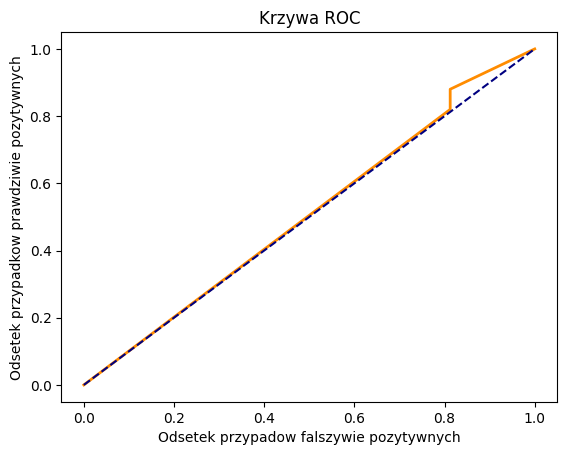

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("Odsetek przypadow falszywie pozytywnych")
plt.ylabel("Odsetek przypadkow prawdziwie pozytywnych")
plt.title("Krzywa ROC")
plt.show()

In [ ]:
# pole pod krzywa ROC
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, pos_prob)

0.520625

### Średno :(
  